In [1]:
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.nn.utils.rnn import PackedSequence, pack_sequence, unpack_sequence, pad_sequence

In [36]:

data = '/kaggle/input/dataset/data_model_v1.csv'



In [37]:
# model

class ExperimentEncoder(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, device=None):
        super().__init__()
        
        if hidden_size % 2 != 0: raise ValueError('Hidden size must be an even number (GRU is bidirectional).')
        gru_hidden_size = hidden_size // 2 # //2 because of bidirectionality
        
        self.embedding = nn.Embedding(8, hidden_size)
        self.gru = nn.GRU(input_size, gru_hidden_size, bidirectional=True, batch_first=True)
        self.initial_hidden_state = nn.Parameter(torch.zeros(2, 1, gru_hidden_size))
        self.device = device
        
    def forward(self, input_):
        if len(input_) != 2:
            raise ValueError('Input must be a tuple of (PackedSequence, Tensor).')
        x, target_position = input_
        
        # x should be a packed sequence
        if not isinstance(x, PackedSequence):
            # mainly a workaround for compatibility to torch.utils.tensorboard.SummaryWriter.add_graph
            # see https://stackoverflow.com/questions/75039985/draw-a-graph-of-a-pytorch-model-which-takes-a-packed-tensor-as-input
            x = pack_sequence(x, enforce_sorted=False)
        
        batch_size = x.unsorted_indices.shape[0]
        embedding = self.embedding(target_position).reshape((batch_size, 2, -1)).permute((1, 0, 2))
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1) + embedding
        factors, _ = self.gru(x, initial_hidden_state)
        factors = unpack_sequence(factors)
        
        return factors
    
    
class NonlinearDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, dropout=0.0, device=None):
        super().__init__()
        
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.nonlinearity = nn.ReLU()
        self.device = device
        
    def forward(self, factors):
        # concatenate all sequences, forward into linear layer and split again
        lengths = [factor.shape[0] for factor in factors]
        cat_fs = torch.cat(factors, dim=0)
        cat_fs = self.dropout(cat_fs)
        rates = self.linear(cat_fs)
        rates = [rate for rate in torch.split(rates, lengths)]
        if self.nonlinearity is not None: rates = [self.nonlinearity(rate) for rate in rates]
        
        return None, None, rates
        
    
class XYDataset(Dataset):
    def __init__(self, X, additional_input, Y):
        self.X = X
        self.additional_input = additional_input
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (self.X[index], self.additional_input[index]), self.Y[index]
    
    
    
def collate_packed_sequences(batch):
    X, y = zip(*batch)
    X = [torch.Tensor(elem).to(device) for elem in X]
    additional_input = torch.from_numpy(np.array(additional_input)).to(device)
    y = [torch.Tensor(elem).to(device) for elem in y]
    return pack_sequence(X, enforce_sorted=False)

def collate_fn(batch):
    sequences, labels = zip(*batch)  # Unpack sequences and labels
    
    # Get the original lengths of each sequence
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.float32())
    
    # Pad the sequences to the length of the longest sequence
    padded_sequences = pad_sequence(sequences, batch_first=True)  # Shape: [batch_size, max_seq_length, num_features]
    
    # Stack the labels (assuming one label per sequence)
    padded_labels = pad_sequence([label for label in labels], batch_first=True)  # Shape: [batch_size, max_seq_length, num_labels]
    
    return padded_sequences, padded_labels, lengths

   
    


In [38]:
# Get the current working directory
current_dir = os.getcwd()

# Define the relative path to the desired directory
relative_path = "data"

# Combine the current directory with the relative path to get the absolute path
absolute_path = os.path.join(current_dir, relative_path)
os.chdir(absolute_path)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/data'

In [ ]:
print(absolute_path)

In [39]:
def create_dataloaders(df, val_set_trial, test_set_trial=None, features_columns=None, label_columns=None, batch_size=None):
    """
    Splits the data into training, validation, and optionally test sets and creates DataLoaders for each.

    Args:
        df (pd.DataFrame): The entire dataframe containing trials, features, and labels.
        val_set_trial (int): The trial number to use for validation.
        test_set_trial (int, optional): The trial number to use for testing. If None, no test set will be created.
        features_columns (list): The list of feature column names.
        label_columns (list): The list of label column names.
        batch_size (int, optional): The batch size for training, validation, and test sets.
            If not provided, batch size is equal to the number of unique trials in each set.

    Returns:
        train_dataloader, val_dataloader, test_dataloader (optional): DataLoader objects for training, validation, and testing.
    """
    # Filter the dataframe to get training, validation, and optionally test sets
    train_set = df[(df['trial'] != val_set_trial) & (df['trial'] != test_set_trial if test_set_trial is not None else True)]
    val_set = df[df['trial'] == val_set_trial]
    
    # Create dataset objects
    train_dataset = TrialDataset(train_set, features_columns, label_columns)
    val_dataset = TrialDataset(val_set, features_columns, label_columns)

    # Determine batch size based on unique trials if not provided
    train_batch_size = batch_size if batch_size else len(train_set['trial'].unique())
    val_batch_size = batch_size if batch_size else len(val_set['trial'].unique())

    # Create DataLoader objects for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, collate_fn=collate_fn, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, collate_fn=collate_fn, shuffle=True)

    # Check if test_set_trial is provided to create test DataLoader
    if test_set_trial is not None:
        test_set = df[df['trial'] == test_set_trial]
        test_dataset = TrialDataset(test_set, features_columns, label_columns)
        test_batch_size = batch_size if batch_size else len(test_set['trial'].unique())
        test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=collate_fn, shuffle=True)
        return train_dataloader, val_dataloader, test_dataloader
    
    return train_dataloader, val_dataloader

In [40]:
def shift_dataframe(df, shift_value, columns_to_shift):
    # Create a copy of the original DataFrame to avoid modifying it
    shifted_df = df.copy()

    # Shift specified columns
    for col in columns_to_shift:
        shifted_df[col] = np.roll(shifted_df[col], shift_value)
    
    # Set the first `shift_value` entries to NaN
    shifted_df.loc[:shift_value - 1, columns_to_shift] = np.nan

    # Drop rows with NaN values
    shifted_df.dropna(inplace=True)

    return shifted_df

In [41]:
class TrialDataset(Dataset):
    def __init__(self, df, X, y):
        self.df = df
        self.X = X
        self.y = y
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Get the features for the trial
        features = trial_data[self.X].values  # Shape: [sequence_length, num_features]
        features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
        
        # Get the labels for the trial (assuming the same label for the entire trial)
        labels = trial_data[self.y].values  # Change this if you need a different structure for labels
        
        return features_tensor, torch.tensor(labels, dtype=torch.float32)

In [42]:
def collate_fn(batch):
    sequences, labels = zip(*batch)  # Unpack sequences and labels

    # Pack the sequences directly
    packed_sequences = pack_sequence(sequences, enforce_sorted=False)  # This will handle variable-length sequences

    # For labels, we can keep them as a list or tensor as per the requirement
    # If labels are of different lengths and you want them as a packed tensor too, consider packing them as well.
    return packed_sequences, labels

In [43]:
# Hyperparameters
test_set = 1
val_set = 2
# Create the dataset and dataloader
shift = 2
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,shift,columns_to_shift)

FileNotFoundError: [Errno 2] No such file or directory: 'data_model_v1.csv'

In [ ]:
print(labels)

In [ ]:
train_dataloader, val_dataloader = create_dataloaders(shifted_df,val_set_trial=val_set,features_columns=columns_to_shift,label_columns=labels)

In [ ]:

# Create the DataLoader
# Hyperparameters
test_set = 1
val_set = 6
# Create the dataset and dataloader
shift = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv(data)
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,shift,columns_to_shift)

train_set = shifted_df[(shifted_df['trial'] != val_set)]
train_dataset = TrialDataset(train_set, X=columns_to_shift, y=labels)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Use batch_size=1
val_set = shifted_df[(shifted_df['trial'] == val_set)]
val_dataset = TrialDataset(val_set, X=columns_to_shift, y=labels)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1

In [ ]:
print(val_set)

In [ ]:
shifted_df[columns_to_shift]

In [ ]:
# Iterate through the DataLoader
for X_batch, y_batch in train_dataloader:
    # features: Shape [1, sequence_length, num_features]
    # labels: Shape [1, num_labels]
    print(X_batch[0].shape[0])
    # Optionally, pack the features for the model
    packed_features = torch.nn.utils.rnn.pack_sequence(X_batch, enforce_sorted=False)
    
    # If needed
    #print((packed_features[0].shape))
    #print(y_batch.shape)
    

In [ ]:
for features, labels in train_dataloader:
    # Move data to the device
    features, labels = features.to(device), labels.to(device)

    # Sort the sequences by length for pack_padded_sequence (if using)
    lengths = [len(f) for f in features]  # Get lengths of sequences in batch
    sorted_lengths, perm_idx = torch.sort(torch.tensor(lengths), descending=True)
    
    features = [features[i] for i in perm_idx]  # Reorder the sequences by length
    
    # Pack the padded sequence (for variable-length sequences)
    packed_features = torch.nn.utils.rnn.pack_sequence(features, enforce_sorted=False)
    
    # Assuming packed_input is your packed sequence
    print("Packed input data shape:", packed_input.data.shape)
    print("Packed input batch sizes:", packed_input.batch_sizes)

    # Forward pass through the model
    outputs = model(packed_features, target_seq_length=len(labels[0]))  # Pass packed sequence

Index(['trial', 'aAngHG_oHead', 'aAngHG_oMid', 'aAngHG_oReach', 'aAngHGFeed1',
       'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4', 'aDistReach_1',
       'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oAngHGFeed1',
       'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4', 'oDistReach1',
       'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1', 's_2', 's_3', 's_4',
       'b_1', 'b_2', 'b_3', 'b_4'],
      dtype='object')
cuda
Epoch [50/100], Train Loss: 0.0167, Validation Loss: 0.0110
Epoch [100/100], Train Loss: 0.0161, Validation Loss: 0.0102


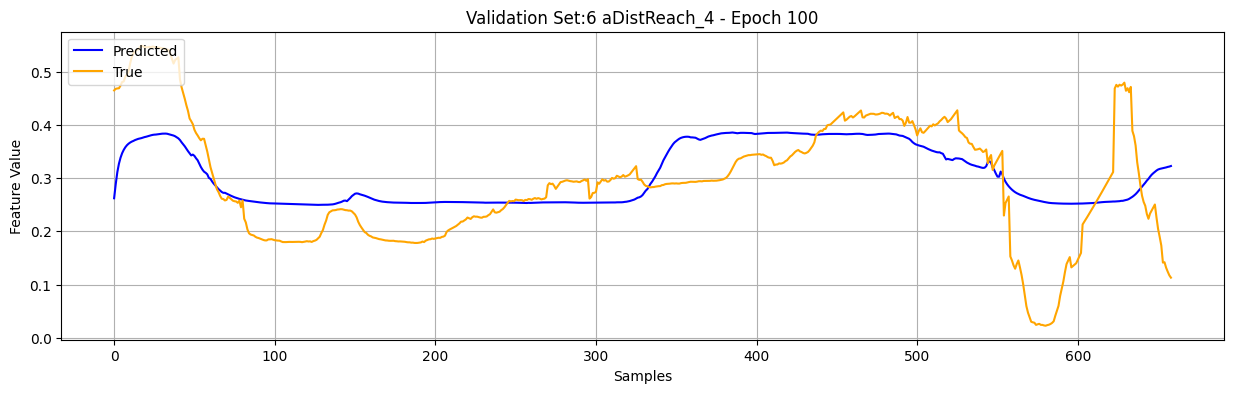

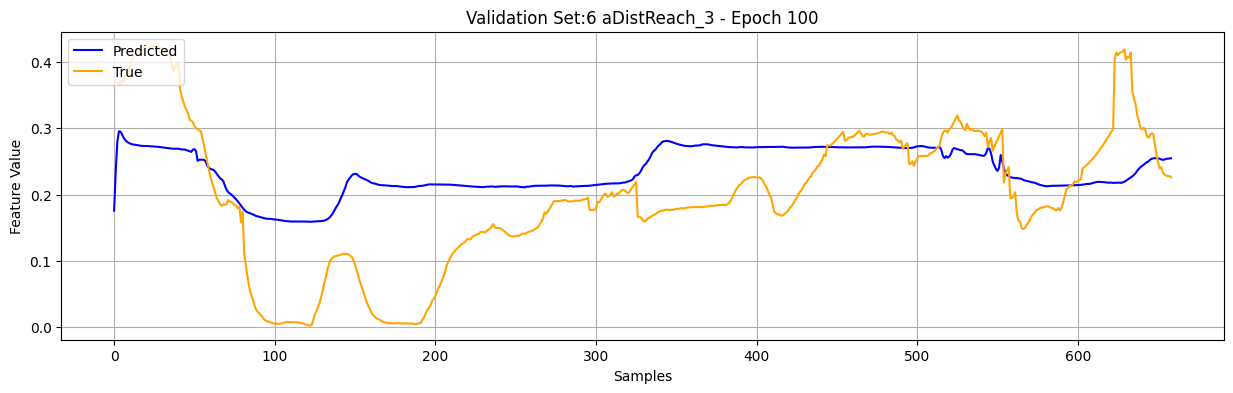

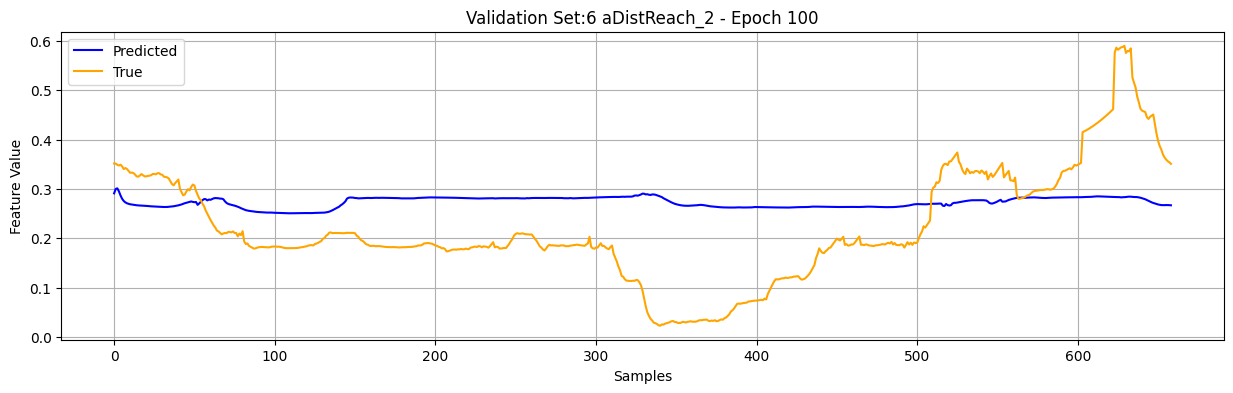

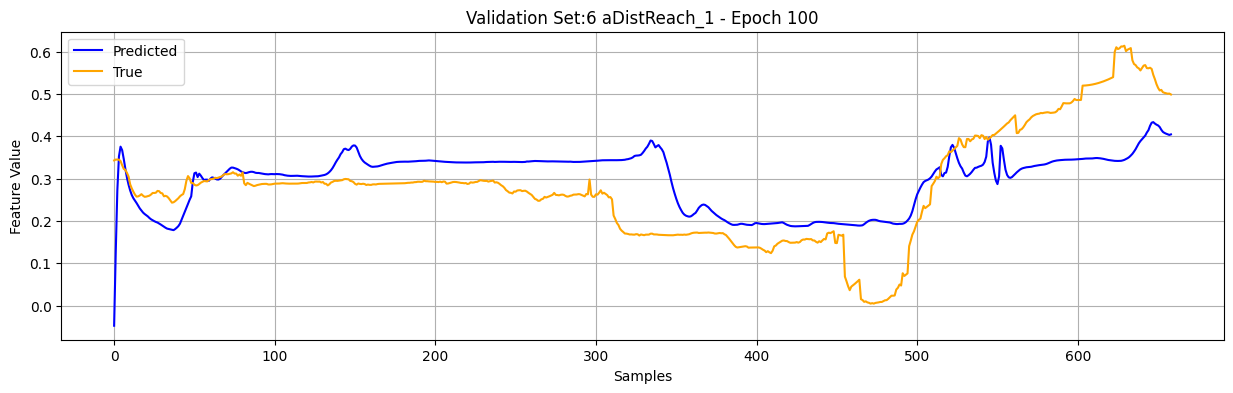

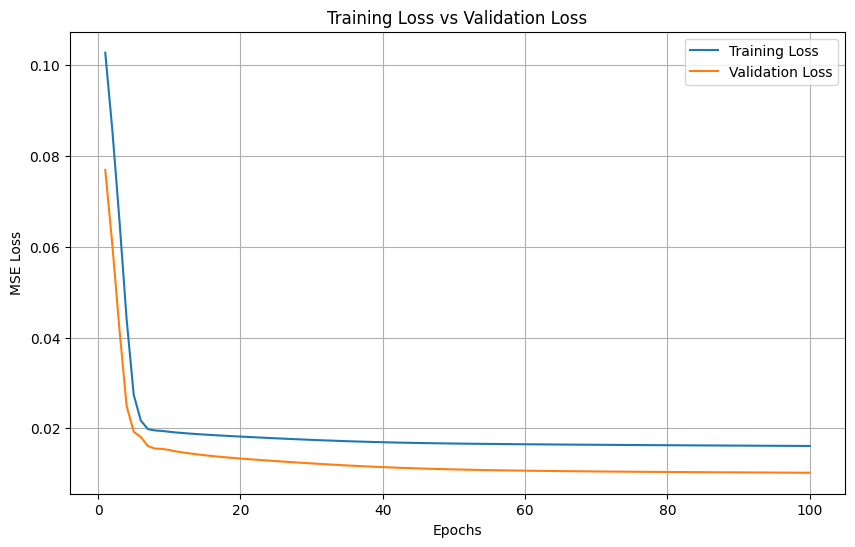

In [118]:
labels = ['aDistReach_4','aDistReach_3','aDistReach_2','aDistReach_1']
columns_to_shift = ['oDistReach4','oDistReach3','oDistReach2','oDistReach1']
set_value = 6
shift = -30
df = pd.read_csv(data)
df = df.drop(columns='id')

save_dir = '/kaggle/working/plots/4d_model'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
#shifted_df = shift_dataframe(df,shift,columns_to_shift)
print(df.columns)
# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(-shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
    
selected_columns = ['trial','aDistReach_1', 'aDistReach_2','aDistReach_3','aDistReach_4',
                    'oDistReach1_minus_30','oDistReach2_minus_30','oDistReach3_minus_30','oDistReach4_minus_30']
shifted_df = shifted_df[selected_columns]
#print(shifted_df.columns)
features = ['oDistReach1_minus_30','oDistReach2_minus_30','oDistReach3_minus_30','oDistReach4_minus_30']
train_set = shifted_df[(shifted_df['trial'] != set_value)]

train_dataset = TrialDataset(train_set, X=features, y=labels)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Use batch_size=1
val_set = shifted_df[(shifted_df['trial'] == set_value)]
val_dataset = TrialDataset(val_set, X=features, y=labels)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1

input_size = 4 # Size of input features
hidden_size = 8  # Hidden size for GRU
output_size = 4  # Size of output features (same as input in this case)
num_layers=1


# Hyperparameters
num_epochs = 100 
learning_rate = 0.001
batch_size = 1  # Adjust based on your needs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


encoder = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, device=device)
decoder = Decoder(hidden_size=hidden_size, output_size=output_size, device=device)

model = Seq2SeqModel(encoder,decoder)
model.to(device)

criterion = nn.MSELoss()  # Use a suitable loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)  # Move data to the device
       
        X = X.squeeze(0)
        #print(X[0][60])
        #print(y[0][30])
        
        optimizer.zero_grad()  # Zero the gradients
        #packed_features = torch.nn.utils.rnn.pack_sequence(features, enforce_sorted=False)
        outputs = model(X)  # Shape should match (batch_size, seq_length, num_output_features)
        loss = criterion(outputs, y)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss) 
        
        # Set the model to evaluation mode (important for certain layers like dropout/batchnorm)
    model.eval()

    # Disable gradient computation for validation (saves memory and computation)
    with torch.no_grad():
        val_loss = 0.0
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)  # Move data to the device
              # Adjust target shape if needed
            X_val = X_val.squeeze(0)
            # Forward pass (no gradients)
            outputs_val = model(X_val)  # Get the model's predictions

            # Compute the validation loss
            loss_val = criterion(outputs_val, y_val)
            val_loss += loss_val.item()  # Accumulate loss for logging

    # After validation, you can calculate the average loss if desired
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss) 
    
    
    
    # Average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
# Convert predictions and actual values to CPU for plotting
y_val_pred_np = outputs_val.detach().cpu().numpy()  # Predicted values
y_val_actual_np = y_val.detach().cpu().numpy()  # Actual values
y_val_pred_np = y_val_pred_np.squeeze(0)
y_val_actual_np = y_val_actual_np.squeeze(0)

num_features = y_val_pred_np.shape[1]  # Number of features


for i in range(num_features):
    plt.figure(figsize=(15, 4))
    
    # Plot for validation data
    plt.plot(y_val_pred_np[:, i], label='Predicted', color='blue')
    plt.plot(y_val_actual_np[:, i], label='True', color='orange')
    
    # Set titles and labels
    plt.title(f'Validation Set:{set_value} {labels[i]} - Epoch {epoch+1}')
    plt.xlabel('Samples')
    plt.ylabel('Feature Value')
    plt.legend(loc='upper left')
    plt.grid()
    plot_filename = f'{save_dir}validation_plot_feature_{i}_epoch_{epoch+1}.png'
    plt.savefig(plot_filename)
    # Show the plot
    plt.show()
    

"""plt.figure(figsize=(15, 4))

# Plot for validation data
plt.plot(val_set['aDistReach_3_minus_30'], label='Lagged', color='blue')
plt.plot(val_set['aDistReach_3'], label='True', color='orange')

# Set titles and labels
plt.title('true values')
plt.xlabel('Samples')
plt.ylabel('Feature Value')
plt.legend(loc='upper left')
plt.grid()

# Show the plot
plt.show()"""
    
# Plot Training vs Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plot_filename = f'{save_dir}_learning_curve_epoch_{epoch+1}.png'
plt.savefig(plot_filename)
plt.show()

In [120]:
# Step 1: Create the Zip File
folder_to_zip = '.'  # Current directory
output_zip_path = 'plots_etc.zip'  # Output zip file name

# Create the zip file
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', folder_to_zip)

# Step 2: Generate a Download Link
download_link = FileLink(output_zip_path)
display(download_link)


/kaggle/working/plots_etc.zip

In [ ]:
labels = ['aDistReach_3']
columns_to_shift = ['aDistReach_3']
set_value = 6
shift = 20
df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')

#shifted_df = shift_dataframe(df,shift,columns_to_shift)

# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
#print(shifted_df.columns)    
selected_columns = ['trial','aDistReach_3', 'aDistReach_3_minus_20']
shifted_df = shifted_df[selected_columns]
print(shifted_df.columns)
columns_to_shift = ['aDistReach_3_minus_20']
train_set = shifted_df[(shifted_df['trial'] != set_value)]
train_dataset = TrialDataset(train_set, X=columns_to_shift, y=labels)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Use batch_size=1
val_set = shifted_df[(shifted_df['trial'] == set_value)]
val_dataset = TrialDataset(val_set, X=columns_to_shift, y=labels)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)  # Use batch_size=1

input_size = 1 # Size of input features
hidden_size = 12# Hidden size for GRU
output_size = 1  # Size of output features (same as input in this case)
num_layers=1


# Hyperparameters
num_epochs = 15
learning_rate = 0.01
batch_size = 1  # Adjust based on your needs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


encoder = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, device=device)
decoder = Decoder(hidden_size=hidden_size, output_size=output_size, device=device)


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if param.dim() > 1:  # Weight matrices
                nn.init.xavier_uniform_(param)

# Initialize the model
model = Seq2SeqModel(encoder, decoder)
model.to(device) 

# Apply custom weight initialization to the model
model.apply(init_weights)

criterion = nn.MSELoss()  # Use a suitable loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)  # Move data to the device
        y = y.squeeze(0)        
        optimizer.zero_grad()  # Zero the gradients
        #packed_features = torch.nn.utils.rnn.pack_sequence(features, enforce_sorted=False)
        outputs = model(X)  # Shape should match (batch_size, seq_length, num_output_features)
        loss = criterion(outputs, y)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Set the model to evaluation mode (important for certain layers like dropout/batchnorm)
    # After validation, you can calculate the average loss if desired
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss) 
    model.eval()

    # Disable gradient computation for validation (saves memory and computation)
    with torch.no_grad():
        val_loss = 0.0
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)  # Move data to the device
            y_val = y_val.squeeze(0)  # Adjust target shape if needed

            # Forward pass (no gradients)
            outputs_val = model(X_val)  # Get the model's predictions

            # Compute the validation loss
            loss_val = criterion(outputs_val, y_val)
            val_loss += loss_val.item()  # Accumulate loss for logging

    # After validation, you can calculate the average loss if desired
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    
    # Average loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss}")
    
# Convert predictions and actual values to CPU for plotting
y_val_pred_np = outputs_val.detach().cpu().numpy()  # Predicted values
y_val_actual_np = y_val.detach().cpu().numpy()  # Actual values

num_features = y_val_pred_np.shape[1]  # Number of features

for i in range(num_features):
    plt.figure(figsize=(14, 8))
    
    # Plot for validation data
    plt.plot(y_val_pred_np[:, i], label='Predicted', color='blue')
    plt.plot(y_val_actual_np[:, i], label='Actual', color='orange')
    
    # Set titles and labels
    plt.title(f'Validation Set:{set_value} {labels[i]} - Epoch {epoch+1}')
    plt.xlabel('Samples')
    plt.ylabel('Feature Value')
    plt.legend(loc='upper right')
    plt.grid()

    # Show the plot
    plt.show()
    
# Plot Training vs Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
    


In [ ]:
labels = ['aDistReach_3']
columns_to_shift = ['aDistReach_3']
val_set = 6
shift = 10
df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
#shifted_df = shift_dataframe(df,shift,columns_to_shift)

# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = shifted_df.append(trial_df, ignore_index=True)
    
selected_columns = ['trial','aDistReach_3', 'aDistReach_3_minus_10']
shifted_df = shifted_df[selected_columns]
train_set = shifted_df[(shifted_df['trial'] != val_set)]
train_dataset = TrialDataset(train_set, X=columns_to_shift, y=labels)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Use batch_size=1
val_set = shifted_df[(shifted_df['trial'] == val_set)]
val_dataset = TrialDataset(val_set, X=columns_to_shift, y=labels)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1

In [ ]:
shifted_df.columns

In [ ]:

# Create the DataLoader
# Hyperparameters
test_set = 1
val_set = 6
# Create the dataset and dataloader
shift = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,shift,columns_to_shift)

train_set = shifted_df[(shifted_df['trial'] != val_set)]
train_dataset = TrialDataset(train_set, X=columns_to_shift, y=labels)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Use batch_size=1
val_set = shifted_df[(shifted_df['trial'] == val_set)]
val_dataset = TrialDataset(val_set, X=columns_to_shift, y=labels)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, device=None):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bias = False)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.initial_hidden_state = nn.Parameter(torch.zeros(num_layers, 1, hidden_size))
        self.device = device

    def forward(self, input_sequence, hidden=None):
        # input_sequence: input tensor of shape (1, sequence_length, input_size)
        
        # Initialize hidden state
        batch_size = input_sequence.size(0)  # Should be 1 in your case
        if hidden is None:
            initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        else:
            initial_hidden_state = hidden
        
        # Forward pass through GRU
        output, hidden_state = self.gru(input_sequence, initial_hidden_state)

        return output, hidden_state  # Return both the output and hidden state

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, device=None):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bias=False)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device  # Store the device

    def forward(self, input_sequence, hidden=None):
        # Ensure the input sequence is on the correct device
        input_sequence = input_sequence.to(self.device)

        # Initialize hidden state
        batch_size = input_sequence.size(0)  # Get the batch size from input sequence
        if hidden is None:
            # Initialize hidden state with the correct shape for GRU on the device
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)

        # Forward pass through GRU
        output, hidden_state = self.gru(input_sequence, hidden)

        return output, hidden_state  # Return both the output and hidden state


class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1, device=None):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bias=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.device = device  # Store the device

    def forward(self, enc_output):
        # Ensure the encoder output is on the correct device
        enc_output = enc_output.to(self.device)

        # Prepare input for the decoder: use the output from the encoder
        decoder_input = enc_output
        decoder_output, _ = self.gru(decoder_input)

        # Output layer (ensure it's on the correct device)
        output = self.fc(decoder_output).to(self.device)

        return output


class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device=None):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device  # Store the device

        # Move encoder and decoder to the device
        self.encoder.to(self.device)
        self.decoder.to(self.device)

    def forward(self, input_sequence):
        # Ensure the input sequence is on the correct device
        input_sequence = input_sequence.to(self.device)

        # Forward pass through the encoder
        enc_output, _ = self.encoder(input_sequence)

        # Forward pass through the decoder
        dec_output = self.decoder(enc_output)

        return dec_output


In [ ]:
# Parameters
input_size = 16  # Number of input features
hidden_size = 10  # Number of hidden units in GRU
num_layers = 1  # Number of GRU layers
batch_size = 1  # Number of sequences in a batch
output_size = 11

# Instantiate the encoder
encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(output_size, hidden_size, num_layers)
model = Seq2SeqModel(encoder,decoder)

for features, labels in train_dataloader:

    # Pack the input sequences
    #features = torch.nn.utils.rnn.pack_sequence(features, enforce_sorted=False)
    #print("input shape:", features.squeeze(0).shape)
    #features = features.squeeze(0)
    print("encoder input shape:", (features.shape))
    # Forward pass through the encoder
    enc_output = encoder(features)
    #print("decoder input shape:", (enc_output[0].shape))
    #print("Packed output shape:", (enc_output[0][:, -1, :].unsqueeze(1).shape()))
    dec_output = decoder(enc_output[0])
    output = model(features)

    print("decoder output shape:", (dec_output.size()))
    print("model output shape:", output.size())
    
    
     #   batch_size = enc_output.size(0)
      #  seq_length = enc_output.size(1)


In [ ]:
# Parameters
input_size = 16  # Number of input features
hidden_size = 1  # Number of hidden units in GRU
num_layers = 1  # Number of GRU layers
batch_size = 1  # Number of sequences in a batch
output_size = 11

# Instantiate the encoder
encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(output_size, hidden_size, num_layers)
model = Seq2SeqModel(encoder,decoder)

for features, labels in train_dataloader:
    output = model(features)
    print("model output shape:", output.size())

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, device=None):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bias=False)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

    def forward(self, input_sequence, hidden=None):
        batch_size = input_sequence.size(0)
        if hidden is None:
            initial_hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        else:
            initial_hidden_state = hidden
        
        # Forward pass through GRU
        output, hidden_state = self.gru(input_sequence, initial_hidden_state)

        # Return the last hidden state (summary of the sequence)
        return hidden_state

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1, device=None):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bias=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, hidden_state):
        batch_size = hidden_state.size(1)  # Hidden state shape: (num_layers, batch_size, hidden_size)

        # Initialize the decoder input as zeros (or optionally the first input from the target sequence)
        decoder_input = torch.zeros(batch_size, 1, hidden_state.size(2)).to(hidden_state.device)  # (batch_size, 1, hidden_size)

        outputs = []
        # For each time step in the sequence
        for _ in range(output_size):  # seq_length should be the desired output sequence length
            decoder_output, hidden_state = self.gru(decoder_input, hidden_state)  # Use last hidden state from encoder
            output = self.fc(decoder_output)
            outputs.append(output)

            # Prepare next input to decoder (auto-regressive, teacher forcing can be added here)
            decoder_input = output  # Feed the predicted output back in as input

        return torch.cat(outputs, dim=1)  # Concatenate the output list along the sequence length 
    
    
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, input_sequence):
        hidden_state = self.encoder(input_sequence)  # Only return the last hidden state
        dec_output = self.decoder(hidden_state)      # Pass the hidden state to the decoder
        return dec_output

# changing to 1 batch with 14 trials

In [ ]:
class TrialDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, X, y):
        self.data = data_frame
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Create a tensor for each feature column
        X = torch.tensor([self.data.iloc[idx][col] for col in self.X], dtype=torch.float32)

        # Create a tensor for each label column
        y = torch.tensor([self.data.iloc[idx][col] for col in self.y], dtype=torch.float32)
        
        return X, y


In [ ]:
labels = ['aDistReach_3']
columns_to_shift = ['aDistReach_3']
set_value = 6
shift = 20
df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')

#shifted_df = shift_dataframe(df,shift,columns_to_shift)

# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
#print(shifted_df.columns)    
selected_columns = ['trial','aDistReach_3', 'aDistReach_3_minus_20']
shifted_df = shifted_df[selected_columns]
print(shifted_df.columns)
columns_to_shift = ['aDistReach_3_minus_20']

In [ ]:
def custom_collate_fn(batch):
    X, y = zip(*batch)  # Unzip the list of tuples into features and labels

    # Pack the feature sequences
    packed_features = pack_sequence(X, enforce_sorted=False)

    # Pack the label sequences (if they are variable length)
    packed_labels = pack_sequence(y, enforce_sorted=False)

    return packed_features, packed_labels

In [ ]:
from torch.utils.data import DataLoader

# Initialize the dataset
train_dataset = TrialDataset(train_set, X=columns_to_shift, y=labels)
val_dataset = TrialDataset(val_set, X=columns_to_shift, y=labels)

# Create DataLoader with batch_size set to 15
train_dataloader = DataLoader(train_dataset, batch_size=15,collate_fn=custom_collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=15,collate_fn=custom_collate_fn, shuffle=True)

for packed_features, packed_labels in train_dataloader:
    print("Packed features:", packed_features)  # Should be a packed sequence
    print("Packed labels:", packed_labels)      # Should be a packed sequence

    # Forward pass through the encoder
    enc_output = encoder(packed_features)

    # Forward pass through the decoder
    dec_output = decoder(enc_output[0])


In [ ]:
input_size = 16  # Number of input features
hidden_size = 10  # Number of hidden units in GRU
num_layers = 1  # Number of GRU layers
batch_size = 1  # Number of sequences in a batch
output_size = 11

# Instantiate the encoder
encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(output_size, hidden_size, num_layers)
model = Seq2SeqModel(encoder,decoder)

for features, labels in train_dataloader:

    # Pack the input sequences
    #features = torch.nn.utils.rnn.pack_sequence(features, enforce_sorted=False)
    #print("input shape:", features.squeeze(0).shape)
    #features = features.squeeze(0)
    print("encoder input shape:", (features.shape))
    # Forward pass through the encoder
    enc_output = encoder(features)
    #print("decoder input shape:", (enc_output[0].shape))
    #print("Packed output shape:", (enc_output[0][:, -1, :].unsqueeze(1).shape()))
    dec_output = decoder(enc_output[0])
    output = model(features)

    print("decoder output shape:", (dec_output.size()))
    print("model output shape:", output.size())
    
    
     #   batch_size = enc_output.size(0)
      #  seq_length = enc_output.size(1)

In [ ]:
# Create your datasets with a batch size of 15
train_set = shifted_df[(shifted_df['trial'] != set_value)]
#train_dataset = TrialDataset(train_set, X=columns_to_shift, y=labels)
#train_dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True)

  

val_set = shifted_df[(shifted_df['trial'] == set_value)]
#val_dataset = TrialDataset(val_set, X=columns_to_shift, y=labels)
#val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)



# Initialize the dataset
train_dataset = TrialDataset(train_set, X=columns_to_shift, y=labels)
val_dataset = TrialDataset(val_set, X=columns_to_shift, y=labels)

# Create DataLoader with batch_size set to 15
train_dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=15, shuffle=False)

# Training Loop
for features, labels in train_dataloader:
    # Pack the input sequences (requires features to be a list of tensors)
    packed_features = torch.nn.utils.rnn.pack_sequence([f.unsqueeze(0) for f in features], enforce_sorted=False)

    # Forward pass through the encoder
    enc_output = encoder(packed_features)

    # Decoder input could be the last hidden state or the packed output
    dec_output = decoder(enc_output[0])
    
    print("Encoder output shape:", enc_output[0].size())
    print("Decoder output shape:", dec_output.size())
